# Allen-Cahn 2D
Goal: solve the Allen-Cahn PDE given as

$
\begin{align}
& u_t - \frac{u_{xx}}{10000} + 5u^3 - 5u = 0, \\
& u(x,0)=x^2cos(\pi x), \\
& u(t,-1)=u(t,1), \\
& u_x(t,-1)=u_x(t,1)
\end{align}
$

where $x \in [-1,1]\text{ and }t \in [0,1]$

In [1]:
from dolfin import *
from time import perf_counter
import scipy.io
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib notebook

# output plot/data directory
output = "solutions/allen-cahn-2d/"

# initial conditions
RANDOM_ICs      = 1
SINGLE_CIRC_ICs = 2
SEVEN_CIRC_ICs  = 3

In [2]:
## parameters
#####################################

(nx, ny) = (100, 100) # mesh points
dt       = 10e-3      # time step
(x0, xf) = (0, 2*pi)  # x-boundaries
(y0, yf) = (0, 2*pi)  # y-boundaries
(lB, uB) = (-1, 1)    # solution constraints

IC       = SEVEN_CIRC_ICs # initial conditions
height   = 1              # double-well potential height (random ICs)
epsilon  = 0.2            # given {0.1, 0.2, 0.05} (circular ICs)

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

In [3]:
class PeriodicBoundary(SubDomain):
    '''Sub domain for Periodic boundary condition'''

    # Left or bottom boundaries are the target domains
    def inside(self, x, on_boundary):
        return (near(x[0], x0) or near(x[1], y0)) and on_boundary

    # Map right boundary to left and top boundary to bottom
    def map(self, x, y):
        y[0] = x[0] - (xf - x0)
        y[1] = x[1] - (yf - y0)

In [4]:
class randomIC(UserExpression):
    '''Randomized uniform distribution over [-height, height]/2'''
    def __init__(self, height, **kwargs):
        np.random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
        self.height = height
    def eval(self, values, x):
        values[0] = self.height * np.random.rand() - self.height/2
    def value_shape(self):
        return()

Circular distributions taken from the paper: [_High Accuracy Benchmark Problems for Allen-Cahn and Cahn-Hilliard Dynamics_](http://www.global-sci.com/intro/article_detail/cicp/13225.html).
### _Benchmark I_
For the single circle:
$$u(x,y,0)=\tanh\biggl(\frac{\sqrt{(x-\pi)^2 + (y-\pi)^2}-2}{\epsilon\sqrt{2}}\biggl)$$
Where $\epsilon$ is a constant in the range of 0.1, 0.2, 0.05

In [5]:
class singleCircIC(UserExpression):
    '''Circular distribution centered in the domain'''
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def eval(self, values, x):
        circ = np.sqrt((x[0] - (xf-x0)/2)**2 + (x[1] - (yf-y0)/2)**2)
        values[0] = (np.tanh(circ - 2)/(epsilon * np.sqrt(2)))
    def value_shape(self):
        return()

### _Benchmark II_
For the set of seven circles:
$$u(x,y,0)=-1+\sum_{i=1}^{7}f\Bigl(\sqrt{(x-x_i)^2+(y-y_i)^2}-r_i\Bigl),$$
with
$$f(s) =
\begin{cases}
    2e^{-\epsilon^2/s^2}, s \lt 0\\
    0, s \ge 0
\end{cases}$$
And the centers $(x_i,y_i)$ and radii $r_i$ given by Table 1.

In [6]:
xi = np.array([pi/2, pi/4,    pi/2,    pi,    3*pi/2, pi,   3*pi/2])
yi = np.array([pi/2, 3*pi/4,  5*pi/4,  pi/4,  pi/4,   pi,   3*pi/2])
ri = np.array([pi/5, 2*pi/15, 2*pi/15, pi/10, pi/10,  pi/4, pi/4  ])
a = pi
np.exp(a/xi**2)

array([  3.57240681, 162.87095155,   3.57240681,   1.37480223,
         1.15196717,   1.37480223,   1.15196717])

In [7]:
class sevenCircIC(UserExpression):
    '''Seven circles at arbitrary locations'''
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def eval(self, values, x):
        xi = np.array([pi/2, pi/4,    pi/2,    pi,    3*pi/2, pi,   3*pi/2])
        yi = np.array([pi/2, 3*pi/4,  5*pi/4,  pi/4,  pi/4,   pi,   3*pi/2])
        ri = np.array([pi/5, 2*pi/15, 2*pi/15, pi/10, pi/10,  pi/4, pi/4  ])
        
        circ = np.sqrt((x[0] - xi)**2 + (x[1] - yi)**2)
        def f(s):
            expr = 2*np.exp(-epsilon**2 / s**2)
            expr[s >= 0] = 0
            return expr
        values[0] = -1 + np.sum(f(circ - ri))
    def value_shape(self):
        return()

In [9]:
# formulate problem
#####################################

# create periodic boundary condition
pbc = PeriodicBoundary()
bc = []

# setup mesh
mesh = RectangleMesh(Point(x0, y0), Point(xf, yf), nx, ny)
V = FunctionSpace(mesh, "CG", 1, constrained_domain=pbc)

# define solution constraints
lowerBound = Expression("lB", lB=lB, degree=0)
upperBound = Expression("uB", uB=uB, degree=0)
uMin = interpolate(lowerBound, V)
uMax = interpolate(upperBound, V)

# define test & trial functions
du = TrialFunction(V)
v = TestFunction(V)

# define functions
u = Function(V)
u0 = Function(V)

# initial conditions
if IC == RANDOM_ICs:
    u_init = randomIC(height, degree=0)
elif IC == SINGLE_CIRC_ICs:
    u_init = singleCircIC(degree=0)
elif IC == SEVEN_CIRC_ICs:
    u_init = sevenCircIC(degree=0)
u.interpolate(u_init)
u0.interpolate(u_init)

W = 1/4 * (u**2 - 1)**2
dWdu = diff(W, u)
F = u*v*dx - u0*v*dx                       \
  + dt*epsilon**2*dot(grad(u), grad(v))*dx \
  + dt*dWdu*v*dx

J = derivative(F, u, du)

<ipython-input-7-f0882aea52bb>:12: RuntimeWarning: divide by zero encountered in true_divide
  expr = 2*np.exp(-epsilon**2 / s**2)


In [10]:
# Create nonlinear variational problem and solver
snes_solver_parameters = {"nonlinear_solver": "snes",
                          "snes_solver": {"linear_solver": "lu"}
                         }

problem = NonlinearVariationalProblem(F, u, bc, J)
# problem.set_bounds(uMin, uMax)
solver = NonlinearVariationalSolver(problem)
# solver.parameters.update(snes_solver_parameters)
info(solver.parameters, True)

In [11]:
# map mesh vertices to solution DOFs
#####################################

dof_coordinates = V.tabulate_dof_coordinates()
u_dofs = V.dofmap().dofs()
dofs  = np.squeeze(dof_coordinates[u_dofs])
ind = np.lexsort((dofs[:,0], dofs[:,1]))
square = len(dofs[ind,0]) % (nx+1) == 0

<IPython.core.display.Javascript object>


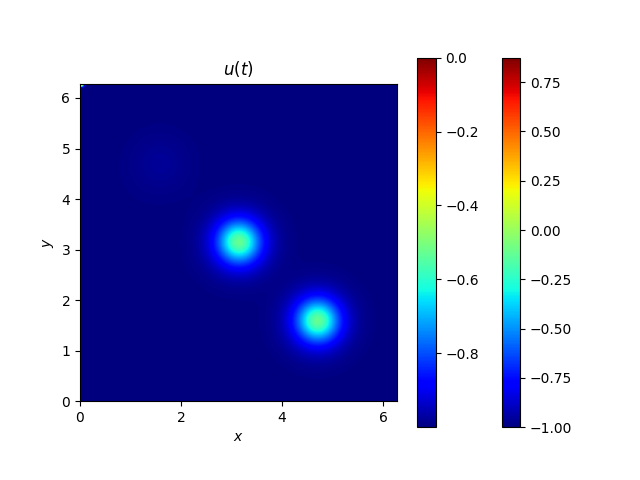

In [12]:
plt.figure()
u_sorted = u0.vector()[u_dofs][ind]
if square:
    u_grid = u_sorted.reshape(nx+1, ny+1)
else:
    u_grid = np.insert(u_sorted, 0, 0).reshape(nx+1, ny+1)
plt.imshow(u_grid, extent=[x0, xf, y0, yf], interpolation='gaussian', cmap='jet')
plt.title(f"$u(t)$")
plt.xlabel("$x$")
plt.ylabel('$y$')
plt.colorbar()
plt.show()

In [14]:
def normalize(data, uMin, uMax):
    '''Scale solution to [uMin, uMax]'''
    data -= data.min()
    data /= data.max()
    data *= uMax - uMin
    data += uMin
    return data

In [15]:
# time stepping
#####################################

(t, T) = (0.0, 3.0)
(n, N) = (0, int(round(T/dt, 0)))

sol = {}
sol['x'] = dofs[ind]
sol['t'] = np.zeros((N,1))
sol['u'] = np.zeros((len(sol['x']), len(sol['t'])))

t0 = perf_counter()
while n < N:
    
    # compute current solution
    solver.solve()
    
    # normalize solution
    # u.vector()[u_dofs] = normalize(u.vector()[u_dofs], lB, uB)
    
    # update previous solution
    u0.vector()[:] = u.vector()
    
    # save output
    sol['t'][n] = t
    sol['u'][:,n] = u.vector()[u_dofs][ind]
    
    # print progress
    if n % round(N/10,0) == 0:
        print(f"{n} / {N}")
        
    # increment time
    t += dt
    n += 1
        

tf = perf_counter()
print(f"\nTook {tf-t0:.2f} seconds.")

0 / 300
30 / 300
60 / 300
90 / 300
120 / 300
150 / 300
180 / 300
210 / 300
240 / 300
270 / 300

Took 44.33 seconds.


In [16]:
plt.figure(1)
u_sorted = u.vector()[u_dofs][ind]
u_grid = np.insert(u_sorted, 0, 0).reshape(nx+1, ny+1)
plt.imshow(u_grid, extent=[x0, xf, y0, yf], interpolation='gaussian', cmap='jet')
plt.title(f"$u(t)$")
plt.xlabel("$x$")
plt.colorbar()
plt.show()

In [17]:
def snapshot(i):
    plt.clf()
    u_sorted = sol['u'][:,i]
    if square:
        u_grid = u_sorted.reshape(nx+1, ny+1)
    else:
        u_grid = np.insert(u_sorted, 0, 0).reshape(nx+1, ny+1)
    plt.imshow(u_grid, extent=[x0, xf, y0, yf], interpolation='bicubic', cmap='jet')
    plt.rc('xtick',labelsize=12)
    plt.rc('ytick',labelsize=15)
    plt.xlabel('$x$',fontsize='x-large')
    plt.ylabel('$y$',fontsize='x-large')
    plt.title(f'Allen-Cahn: $\epsilon={epsilon}$')
    plt.colorbar()

<IPython.core.display.Javascript object>


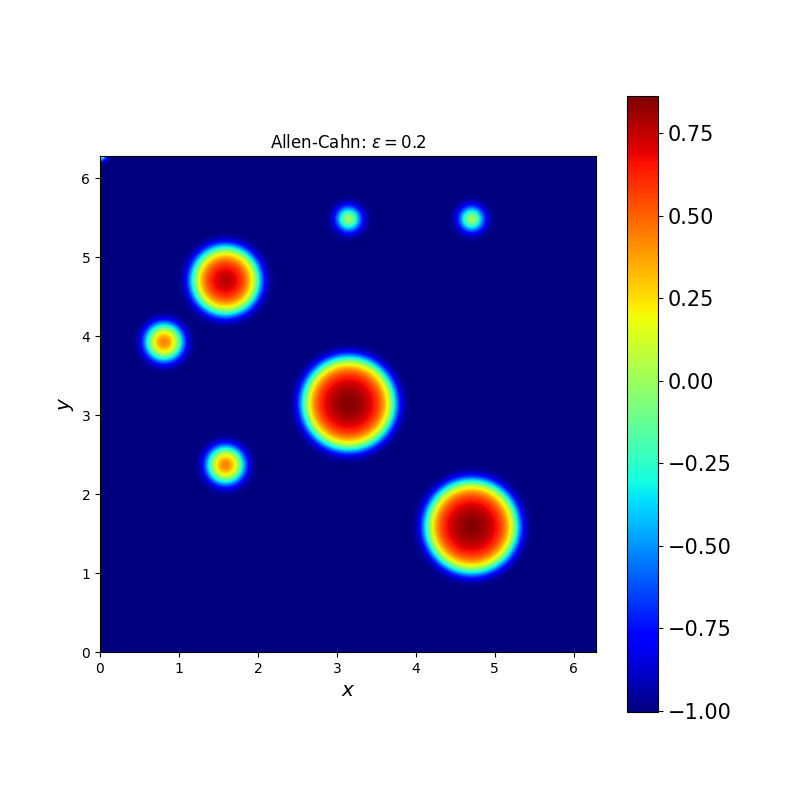

In [18]:
fig = plt.figure(figsize=(8,8), dpi=100)
snapshot(1)

<IPython.core.display.Javascript object>


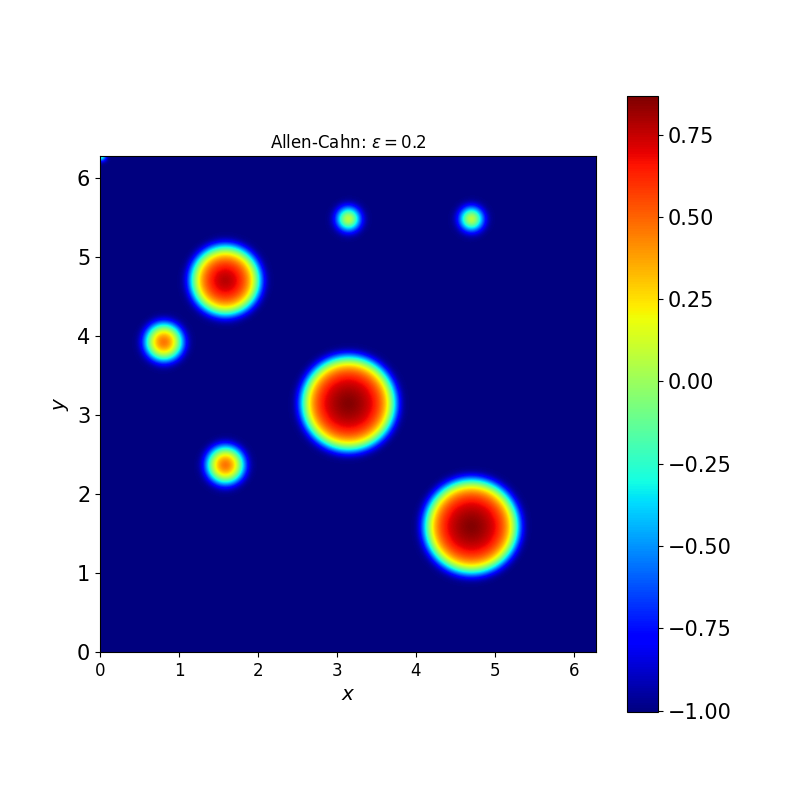

In [19]:
fig = plt.figure(figsize=(8,8), dpi=100)
anim = animation.FuncAnimation(fig,snapshot,frames=N)
if IC == RANDOM_ICs:
    gifname = f'allen-cahn-2d_rand_{epsilon}.mp4'
elif IC == SINGLE_CIRC_ICs:
    gifname = f'allen-cahn-2d_circ1_{epsilon}.mp4'
elif IC == SEVEN_CIRC_ICs:
    gifname = f'allen-cahn-2d_circ7_{epsilon}.mp4'
anim.save(output + gifname, fps=N/10)